In [2]:
%load_ext autoreload
%autoreload 2
import counterfeit_utils as cfu
import cf_value as cfv
import cf_ownership as cfo
import sys
sys.path.append('..')
import data_retrieval.psql_methods as psql
import pandas as pd


In [3]:
look_sims = cfu.get_all_look_sims()

In [15]:
command = f"SELECT slug,token_id,sale_price from cf_sales where slug in {tuple(look_sims)}"
temp_stats_tuples = psql.execute_commands([command])
columns = ['slug','token_id', 'sale_price']
sales_df = pd.DataFrame(temp_stats_tuples,columns=columns)

In [ ]:
slugs = sales_df['slug'].unique()
ls_set = set(look_sims)
ls_slugs = [slug for slug in slugs if slug in ls_set]
print(len(ls_slugs))
print(len(slugs))

In [4]:
command = f"Create table look_sim_sales as SELECT * from cf_sales where slug in {tuple(look_sims)}"
# temp_stats_tuples = psql.execute_commands([command])

In [ ]:
print(command)

In [ ]:
cfv.retreive_full_time_series(look_sims,table_name='look_sim_sales',log_file='look_sim_series.log')

In [ ]:
top_slug = '0n1-force'
look_sims = cfu.get_look_sims(top_slug,remove_ders=True)
sales_df = cfo.get_ownership_sales(top_slug,tuple(look_sims))


In [ ]:
date_df = cfo.get_ownership_dates(top_slug,sales_df)

In [ ]:
for name,group in date_df.groupby('slug_orig'):
    print(name,len(group),len(group.query('timestamp_orig<timestamp')))


In [ ]:
df = pd.read_pickle('ownership_results.pkl')
df

In [17]:
df = cfo.add_creation_dates(df)

In [ ]:
df_filt = df.query('slug_creation_date<look_sim_creation_date')
df_filt['reference_first'].sum()/df_filt['num_owners'].sum()
df_filt_grouped = df_filt.groupby('slug').agg({'reference_first':'sum','num_owners':'sum'})
ratio_list = []
num_more = 0
for name,group in df_filt_grouped.iterrows():
    print(name,group['reference_first']/group['num_owners'])
    ratio = group['reference_first']/group['num_owners']
    ratio_list.append(group['reference_first']/group['num_owners'])
    if ratio>0.5:
        num_more+=1
#describe ratio list
pd.Series(ratio_list).describe(percentiles=[0.05,0.1,0.25,0.75,0.9,.95])
print(num_more/len(ratio_list))

In [ ]:
df_filt['ll_ratio'] = df_filt['ll_first']/df_filt['num_owners']
df_filt.query('ll_first>100').sort_values('ll_ratio',ascending=False).head(20)

In [ ]:
slug = 'wonderpals'
look_sims = cfu.get_look_sims(slug,remove_ders=True)
sales_df = cfo.get_ownership_sales(slug,tuple(look_sims))
date_df = cfo.get_ownership_dates(slug,sales_df)

In [14]:
date_df['look_sim'] = date_df['slug_orig']
date_df = cfo.add_creation_dates(date_df)


In [15]:
date_df_filt = date_df.query('slug_creation_date<look_sim_creation_date')

In [ ]:
sale_ratios = date_df_filt.query('timestamp_orig>timestamp')['sale_price']
sale_ratios_2 = date_df_filt.query('timestamp_orig<timestamp')['sale_price']
#get rid of outlier data
sale_ratios = sale_ratios[sale_ratios<100]
#cdf of sale ratios
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.figure(figsize=(10,6))
plt.hist(sale_ratios,bins=100,density=True,cumulative=True,histtype='step',label='reference first')
plt.hist(sale_ratios_2,bins=100,density=True,cumulative=True,histtype='step',label='Look Sim first')
plt.legend()

In [ ]:
sale_ratios_ll,sale_ratios_ref = cfo.make_ownership_sale_price_df()

In [3]:
import pickle
result_tup = (sale_ratios_ll,sale_ratios_ref)
with open('ownership_results_ratio.pkl','wb') as f:
    pickle.dump(result_tup,f)

In [ ]:
import pickle
with open('ownership_results_ratio.pkl','rb') as f:
    result_tup = pickle.load(f)

1296


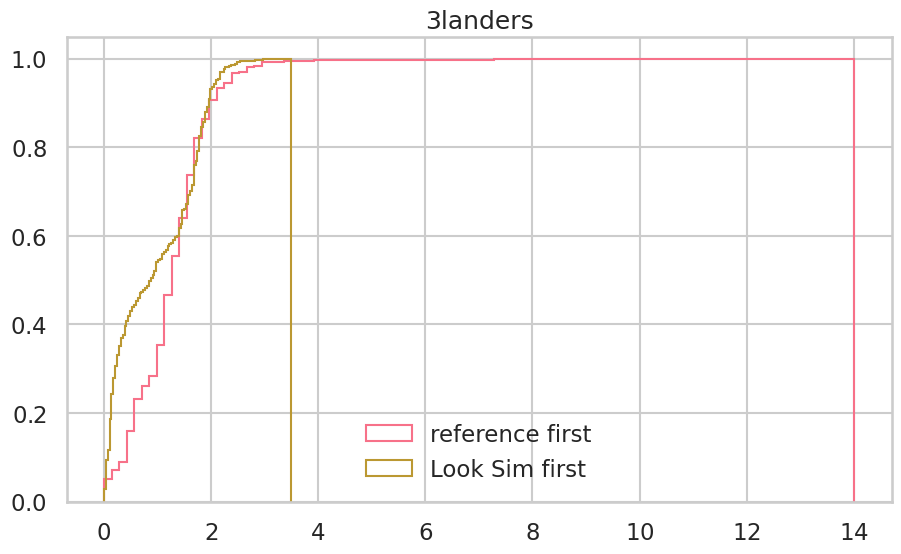

1.3 0.9
1574


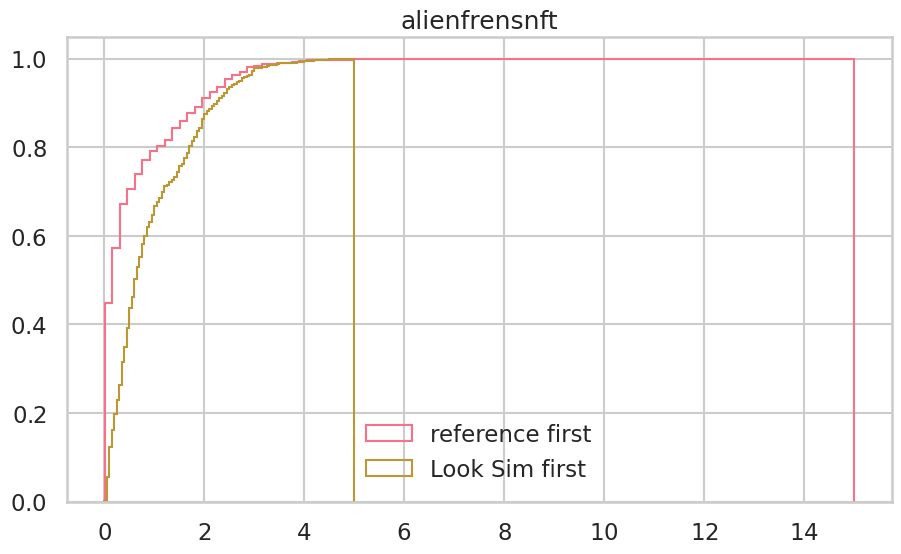

0.22000000000000003 0.649
1956


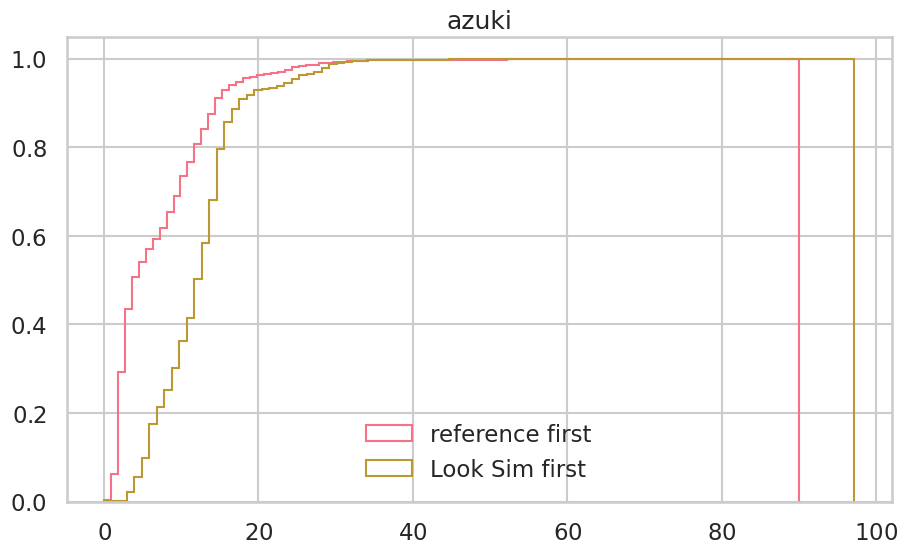

4.390000000000001 12.57
5284


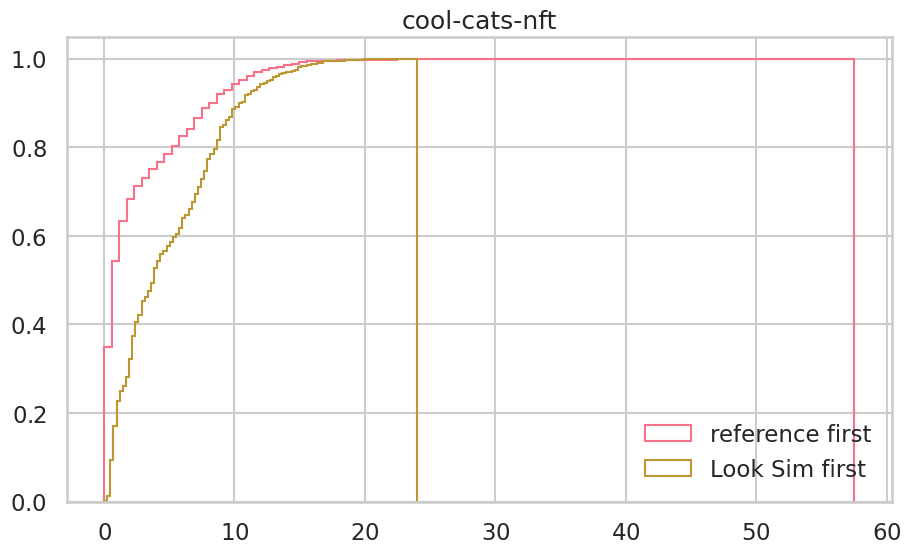

0.91 3.9000000000000004
2670


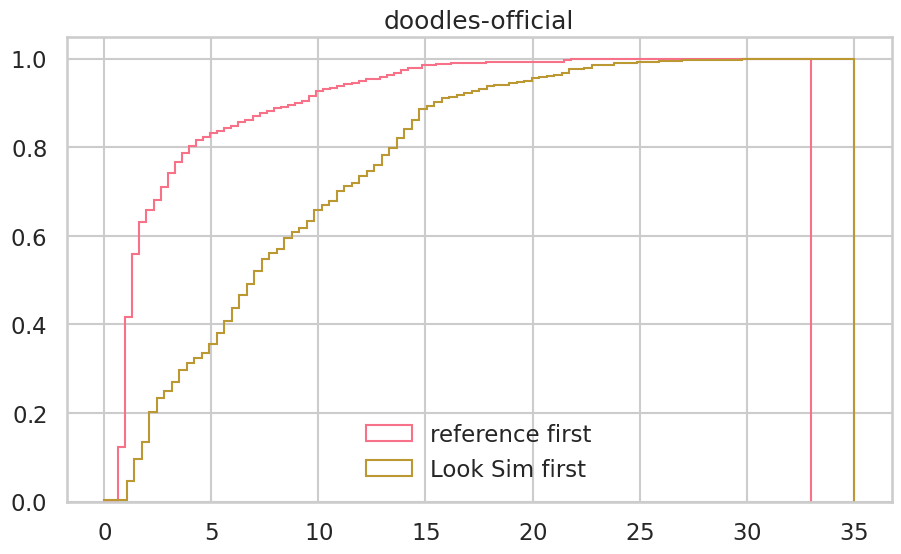

1.4800000000000002 7.000000000000001
1143


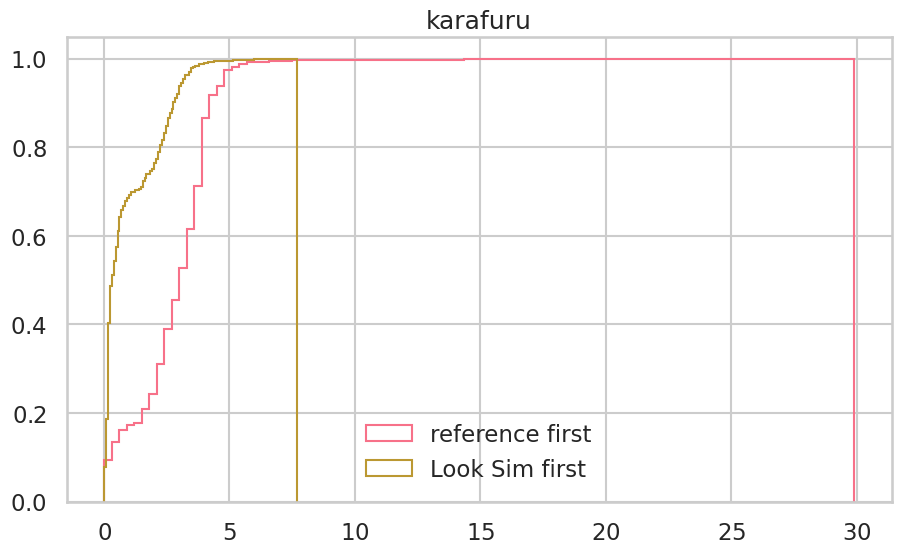

3.1500000000000004 0.35000000000000003
1156


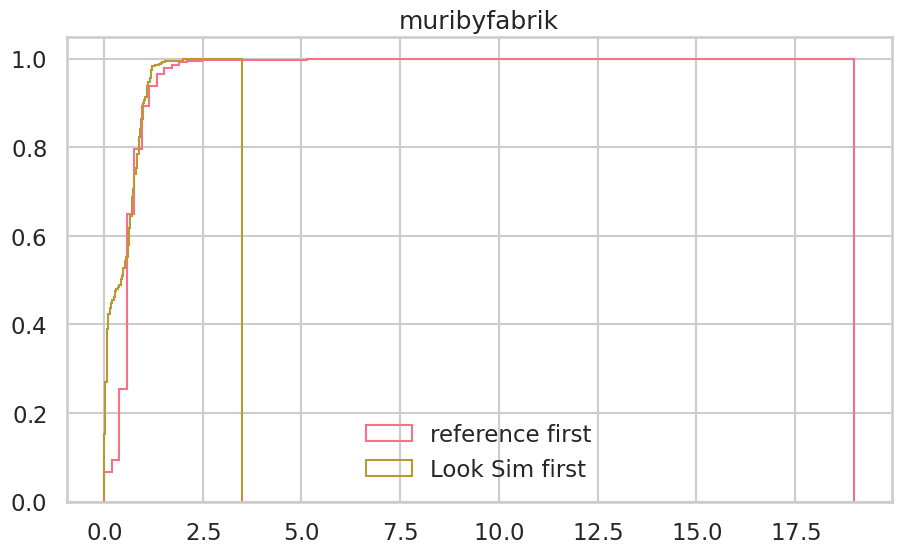

0.6755 0.45
1407


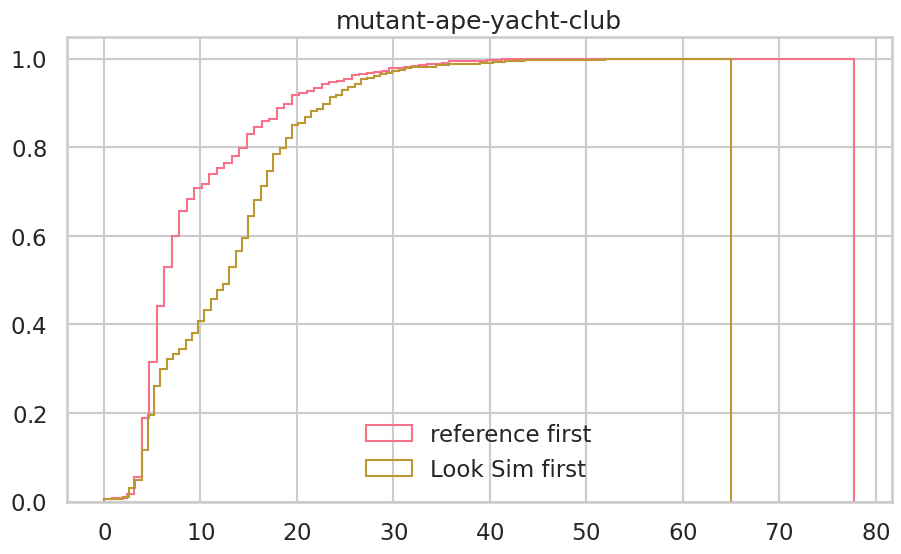

6.800000000000001 13.13
2198


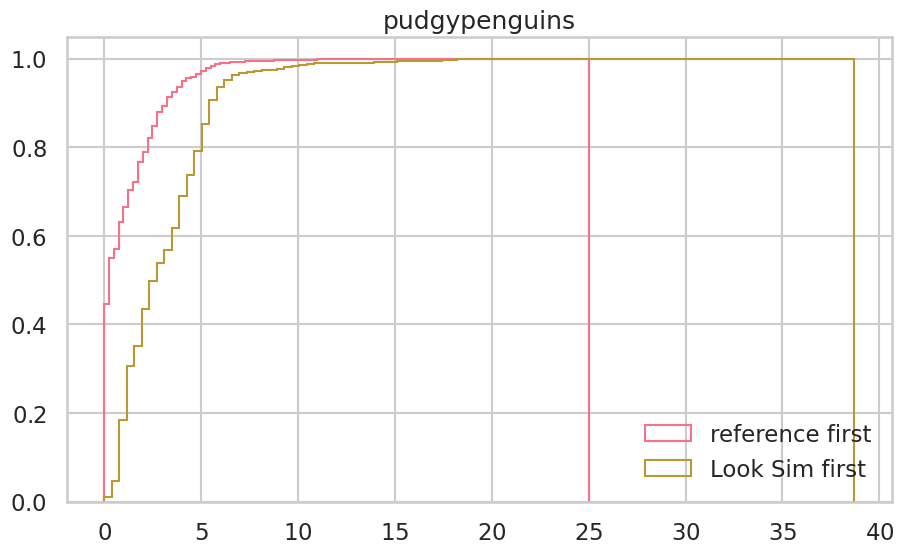

0.389 2.75
1302


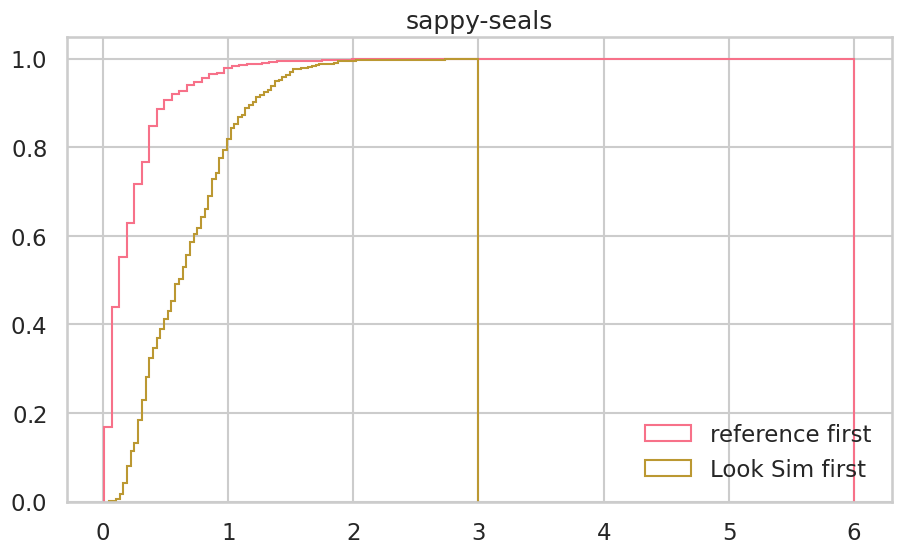

0.15000000000000002 0.63
2800


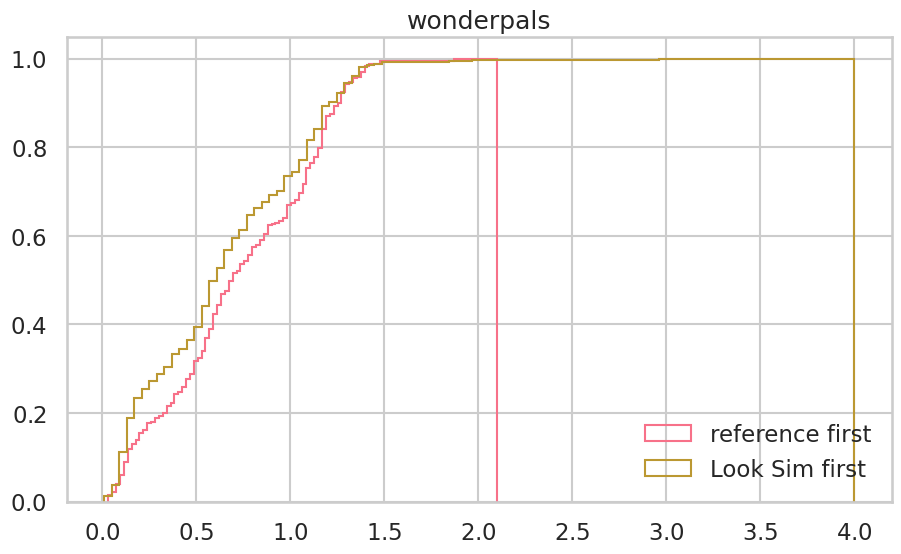

0.6969000000000001 0.6100000000000001
\begin{tabular}{rcc}
\toprule
slug & avg_sale_ref & avg_sale_ll \\
\midrule
3landers & 1.30 & 0.90 \\
alienfrensnft & 0.22 & 0.65 \\
azuki & 4.39 & 12.57 \\
cool-cats-nft & 0.91 & 3.90 \\
doodles-official & 1.48 & 7.00 \\
karafuru & 3.15 & 0.35 \\
muribyfabrik & 0.68 & 0.45 \\
mutant-ape-yacht-club & 6.80 & 13.13 \\
pudgypenguins & 0.39 & 2.75 \\
sappy-seals & 0.15 & 0.63 \\
wonderpals & 0.70 & 0.61 \\
\bottomrule
\end{tabular}



In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sale_ratios_ll = result_tup[0]
sale_ratios_ref = result_tup[1]
df_ll = sale_ratios_ll
df_ref = sale_ratios_ref
df_ll_group = df_ll.groupby('slug')
slugs_for_wal_sales = []
table_results = []
for name,group in df_ll_group:
    if len(group)<1000:
        continue
    print(len(group))
    slugs_for_wal_sales.append(name)    
    sale_ratios_2 = group['sale_price_ref']
    avg_sale_2 = group['sale_price_ref'].median()
    sale_ratios = df_ref.query('slug==@name')['sale_price_ref']
    avg_sale = df_ref.query('slug==@name')['sale_price_ref'].median()
    sale_ratios = sale_ratios[sale_ratios<100]
    sale_ratios_2 = sale_ratios_2[sale_ratios_2<100]
    sns.set()
    sns.set_context("talk")
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    plt.figure(figsize=(10,6))
    plt.hist(sale_ratios,bins=100,density=True,cumulative=True,histtype='step',label='reference first')
    plt.hist(sale_ratios_2,bins=100,density=True,cumulative=True,histtype='step',label='Look Sim first')
    plt.legend()
    plt.title(name)
    plt.show()
    table_results.append([name,avg_sale,avg_sale_2])
    print(avg_sale,avg_sale_2)
#make table results in a dataframe and then a latex table
table_df = pd.DataFrame(table_results,columns=['slug','avg_sale_ref','avg_sale_ll'])
table_df = table_df.sort_values('slug').round(2)
print(table_df.to_latex(float_format="%.2f",column_format="r" + "c" * (len(table_df.columns) - 1), escape=False,
                        index=False))

In [30]:
slug = 'doodles-official'
cfu.plot_price_chart_smooth(slug)

In [ ]:
plt.show()

In [ ]:
slug = 'doodles-official'
look_sims = cfu.get_look_sims(slug,remove_ders=True)
sales_df = cfo.get_ownership_sales(slug,tuple(look_sims))
date_df = cfo.get_ownership_dates(slug,sales_df)

In [5]:
date_df['look_sim'] = date_df['slug_orig']
date_df = cfo.add_creation_dates(date_df)
date_df = date_df.query('slug_creation_date<look_sim_creation_date')

In [ ]:
import matplotlib.pyplot as plt
dates = list(date_df.query('timestamp_orig<timestamp')['timestamp'])
# dates = list(date_df.query('timestamp_orig>timestamp')['timestamp'])
cfu.plot_price_chart_smooth(slug,date_list=dates)
plt.show()

In [ ]:
date_df

In [7]:
slug='cool-cats-nft'
wallet_sales_2 = cfo.get_wallet_sales_distro(slug,'ref_only',norm=False)
wallet_sales_1 = cfo.get_wallet_sales_distro(slug,'ll_first')


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


syntax error at or near ")"
LINE 1: ...,sale_price from look_sim_sales where slug in ('',) and (pay...
                                                             ^

16052
13371


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


11899


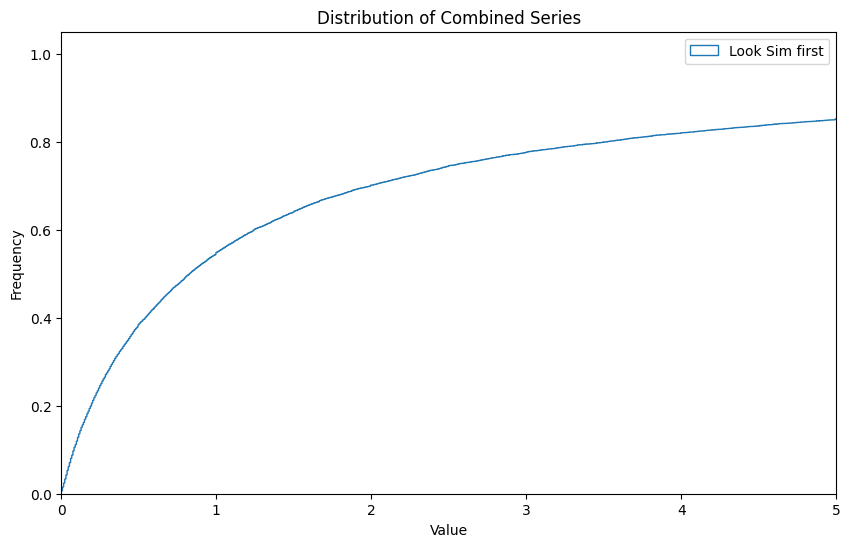

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#Turn wallet sales from a list of series into one big list and then plot
#iterate through fils in ownership_out directory
import os
import pickle

# Define the directory containing the pickle files
directory = 'ownership_out'

# Step 1: List all files in the directory
all_files = os.listdir(directory)

# Step 2: Filter the list to include only pickle files
pickle_files = [f for f in all_files if f.endswith('.pkl') or f.endswith('.pickle')]
max_values = []
# Step 3: Iterate through the list of pickle files and open each one
for pickle_file in pickle_files:
    file_path = os.path.join(directory, pickle_file)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        slug,wallet_sales_1 = data
        max_values += [series.max() for series in wallet_sales_1]
combined_series = pd.Series(max_values)
percentile_99 = combined_series.quantile(0.99)

# Step 3: Filter out values above the 99th percentile
filtered_series = combined_series[combined_series <= percentile_99]
# Step 2: Convert the combined Series to a list
combined_list = filtered_series.tolist()
plt.figure(figsize=(10, 6))
print(len(set(combined_list)))
plt.hist(combined_list,bins=10000,density=True,cumulative=True,histtype='step',label='Look Sim first')
plt.xlim(0, 5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Combined Series')
plt.show()

In [9]:
wallet_sales_2

[('0xa36eeb3ecf6d39768abc61fdf56759913a172344',
  84739       0.400
  1417600     0.950
  1418911     0.480
  9469777     0.300
  1778139     0.248
  1778237     0.300
  1778275     0.400
  1778839     0.250
  1778927     0.230
  1779117     0.230
  1779172     0.470
  1779546     0.850
  1779694     0.385
  5960632     0.120
  10851300    0.400
  16326684    0.950
  16328067    0.480
  Name: sale_price, dtype: float64),
 ('0xb02690b16fd8696ef13a63e3272404b3ea12d00e',
  188692      0.450000
  889248      1.350000
  889256      5.000000
  889339      0.250000
  889344      0.140000
                ...   
  14471504    5.000000
  14471588    0.250000
  14471590    0.140000
  16032225    0.087318
  16032230    0.300000
  Name: sale_price, Length: 72, dtype: float64),
 ('0x6f3379166e074319f983fe4f4ea520c17f595fa5',
  600089    0.2
  Name: sale_price, dtype: float64),
 ('0xe0fcdee8b218a96f669db5096c0c51cf7732974c',
  Series([], Name: sale_price, dtype: float64)),
 ('0x11d80cab11a96a5624c06b

In [ ]:
date_df = cfo.make_one_date_df(slug)

In [ ]:
date_df['sale_price'].describe()

In [13]:
slug = 'cool-cats-nft'
data = cfo.get_ownership_sales(slug,('',))
data['buyer'].nunique()

syntax error at or near ")"
LINE 1: ...,sale_price from look_sim_sales where slug in ('',) and (pay...
                                                             ^



16054

In [2]:
command = f"SELECT slug,token_id,buyer,timestamp,transaction,sale_price from look_sim_sales where (payment_token='WETH' or payment_token='ETH')"
temp_stats_tuples = psql.execute_commands([command])
columns = ['slug','token_id', 'buyer','timestamp','transaction','sale_price']
sales_df = pd.DataFrame(temp_stats_tuples,columns=columns)
del temp_stats_tuples
sales_df = sales_df.drop_duplicates(subset='transaction')
sales_df.drop(columns=['transaction'], inplace=True)
#seperate query for top_slug
command = f"SELECT slug,token_id,buyer,timestamp,transaction,sale_price from cf_sales where (payment_token='WETH' or payment_token='ETH')"
temp_stats_tuples = psql.execute_commands([command])
top_sales_df = pd.DataFrame(temp_stats_tuples,columns=columns)
del temp_stats_tuples
top_sales_df = top_sales_df.drop_duplicates(subset='transaction')
top_sales_df.drop(columns=['transaction'], inplace=True)
sales_df = pd.concat([sales_df,top_sales_df])
sales_df = sales_df[sales_df['buyer'].isin(wallets)]

NameError: name 'wallets' is not defined

In [26]:
slug = 'pudgypenguins'
data = cfo.get_ownership_sales(slug,('',))
wallets = data['buyer'].unique()
sales_df = sales_df[sales_df['buyer'].isin(wallets)]

syntax error at or near ")"
LINE 1: ...,sale_price from look_sim_sales where slug in ('',) and (pay...
                                                             ^



KeyboardInterrupt: 

In [8]:
wallet_sales_1

[1285008     0.161290
 1285115     0.241935
 1285507     0.128871
 1340534     0.298387
 1340718     0.112903
 1340738     0.129032
 2856923     0.112903
 6479949     0.096774
 4900766     0.112903
 7028377     0.070968
 9932572     6.274194
 9937943     2.419355
 9943090     0.717742
 11835598    0.643548
 11835608    0.805645
 11835685    0.594516
 13537408    0.362903
 13542409    0.564516
 13543357    0.645161
 14057969    0.483871
 14755697    0.322581
 14755913    0.467742
 15861087    0.161290
 15861173    0.241935
 15861583    0.128871
 16038222    0.298387
 16038517    0.112903
 16038574    0.129032
 Name: sale_price, dtype: float64,
 81196       1.27200
 81305       1.11200
 81811       1.12000
 87009       0.17776
 87023       0.20000
 1340443     0.05600
 1340733     0.12000
 1340737     0.09600
 1422262     0.26400
 1423007     0.26400
 1424070     0.08000
 1424099     0.08800
 1426020     0.02400
 1721172     0.14400
 2853976     0.15200
 208257      0.14400
 667421      

In [6]:
wallet_sales_1[0]

1285008     0.1000
1285115     0.1500
1285507     0.0799
1340534     0.1850
1340718     0.0700
1340738     0.0800
2856923     0.0700
6479949     0.0600
4900766     0.0700
7028377     0.0440
9932572     3.8900
9937943     1.5000
9943090     0.4450
11835598    0.3990
11835608    0.4995
11835685    0.3686
13537408    0.2250
13542409    0.3500
13543357    0.4000
14057969    0.3000
14755697    0.2000
14755913    0.2900
15861087    0.1000
15861173    0.1500
15861583    0.0799
16038222    0.1850
16038517    0.0700
16038574    0.0800
Name: sale_price, dtype: float64

In [13]:
print(slugs_for_wal_sales)

['3landers', 'alienfrensnft', 'azuki', 'cool-cats-nft', 'doodles-official', 'karafuru', 'muribyfabrik', 'mutant-ape-yacht-club', 'pudgypenguins', 'sappy-seals', 'wonderpals']


In [3]:
slug = 'pudgypenguins'
look_sims = cfu.get_look_sims(slug,remove_ders=True)
sales_df = cfo.get_ownership_sales(slug,tuple(look_sims))

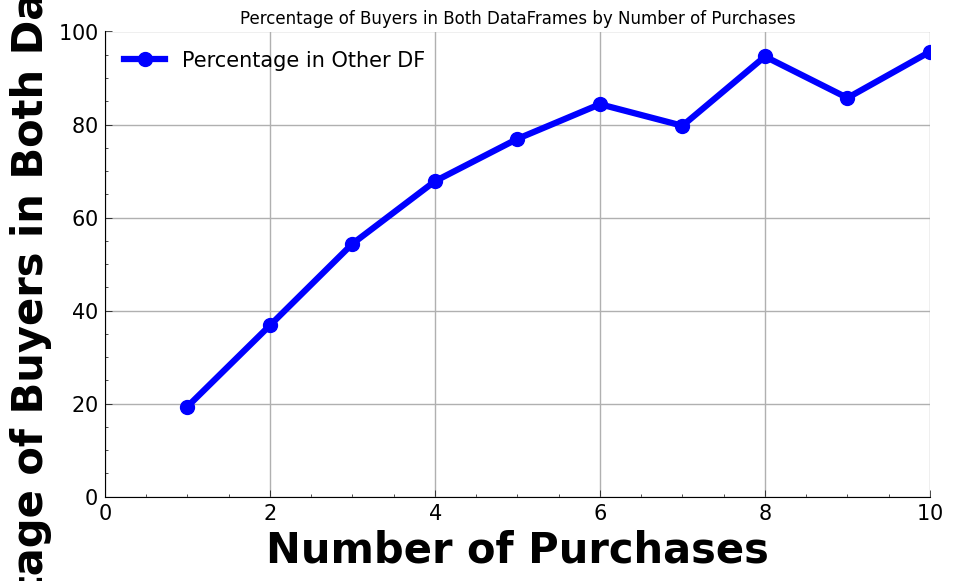

In [5]:
import matplotlib.pyplot as plt
# Step 1: Merge the DataFrames to identify buyers in both DataFrames
df_merged = buyer_group.merge(sales_df_ref, on='buyer', how='left', indicator=True)
df_merged['in_other_df'] = df_merged['_merge'] == 'both'
# Step 2: Calculate the percentage of buyers for each possible value of num_purchases who appear in the other DataFrame
percentages = df_merged.groupby('num_purchases')['in_other_df'].mean() * 100  # Convert to percentage

# Step 3: Plot the percentages using a line plot
plt.figure(figsize=(10, 6))
plt.plot(percentages.index, percentages, marker='o', linestyle='-', color='blue', label='Percentage in Other DF')

# Customize the plot
plt.xlabel('Number of Purchases')
plt.ylabel('Percentage of Buyers in Both DataFrames')
plt.title('Percentage of Buyers in Both DataFrames by Number of Purchases')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.legend()
plt.xlim(0, 10)
plt.grid(True)
plt.show()

In [6]:
results = []
for slug in slugs_for_wal_sales:
    counts_combined = cfo.num_lls_to_purchase_prob(slug)
    print(slug)
    print(counts_combined)
    # Step 4: Plot the ratios using a line plot
    # plt.figure(figsize=(10, 6))
    # plt.plot(counts_combined.index, counts_combined['ratio'], marker='o', linestyle='-', color='blue', label='Ratio of DF1 to Total')
    results.append((slug,counts_combined))
    # # Customize the plot
    # plt.xlabel('Number of Purchases')
    # plt.ylabel('Ratio of DF1 to Total')
    # plt.title('Ratio of Number of Values in DF1 to Total Number in Both DataFrames')
    # plt.ylim(0, 0.2)  # Set y-axis limit to 1
    # plt.legend()
    # plt.xlim(0,5)
    # plt.grid(True)
    # plt.show()
with open('ownership_num_purchases.pkl','wb') as f:
    pickle.dump(results,f)

/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


3landers
                 df1    df2    total     ratio
num_purchases                                 
1              849.0  65496  66345.0  0.012797
2              176.0   6935   7111.0  0.024750
3               24.0   1255   1279.0  0.018765
4                2.0    270    272.0  0.007353
5                2.0     86     88.0  0.022727
6                1.0     21     22.0  0.045455
7                0.0     11     11.0  0.000000
8                0.0      2      2.0  0.000000
9                0.0      2      2.0  0.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


alienfrensnft
                  df1    df2    total     ratio
num_purchases                                  
1              1084.0  66866  67950.0  0.015953
2               173.0   8844   9017.0  0.019186
3                31.0   1996   2027.0  0.015294
4                 6.0    556    562.0  0.010676
5                 3.0    174    177.0  0.016949
6                 2.0     63     65.0  0.030769
7                 0.0     23     23.0  0.000000
8                 0.0     14     14.0  0.000000
9                 0.0      6      6.0  0.000000
10                0.0      1      1.0  0.000000
11                0.0      1      1.0  0.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


azuki
                 df1      df2    total     ratio
num_purchases                                   
1              838.0  82217.0  83055.0  0.010090
2              261.0  11908.0  12169.0  0.021448
3               84.0   3243.0   3327.0  0.025248
4               28.0   1125.0   1153.0  0.024284
5               16.0    480.0    496.0  0.032258
6                7.0    186.0    193.0  0.036269
7                1.0     82.0     83.0  0.012048
8                0.0     50.0     50.0  0.000000
9                1.0     24.0     25.0  0.040000
10               0.0     15.0     15.0  0.000000
11               0.0      8.0      8.0  0.000000
12               1.0      6.0      7.0  0.142857
13               1.0      2.0      3.0  0.333333
28               0.0      1.0      1.0  0.000000
31               1.0      0.0      1.0  1.000000
40               1.0      0.0      1.0  1.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


cool-cats-nft
                  df1      df2     total     ratio
num_purchases                                     
1              1554.0  98478.0  100032.0  0.015535
2               542.0  20333.0   20875.0  0.025964
3               255.0   6781.0    7036.0  0.036242
4               137.0   2880.0    3017.0  0.045409
5                77.0   1364.0    1441.0  0.053435
6                39.0    679.0     718.0  0.054318
7                25.0    352.0     377.0  0.066313
8                15.0    190.0     205.0  0.073171
9                12.0     91.0     103.0  0.116505
10                5.0     63.0      68.0  0.073529
11                4.0     30.0      34.0  0.117647
12                4.0     32.0      36.0  0.111111
13                2.0     11.0      13.0  0.153846
14                2.0     11.0      13.0  0.153846
15                0.0      6.0       6.0  0.000000
16                2.0      2.0       4.0  0.500000
17                1.0      3.0       4.0  0.250000
18               

/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


doodles-official
                  df1       df2     total     ratio
num_purchases                                      
1              1028.0  102594.0  103622.0  0.009921
2               316.0   18488.0   18804.0  0.016805
3               134.0    5839.0    5973.0  0.022434
4                55.0    2198.0    2253.0  0.024412
5                30.0    1034.0    1064.0  0.028195
6                12.0     452.0     464.0  0.025862
7                 7.0     223.0     230.0  0.030435
8                 4.0     125.0     129.0  0.031008
9                 0.0      67.0      67.0  0.000000
10                1.0      42.0      43.0  0.023256
11                1.0      27.0      28.0  0.035714
12                0.0       9.0       9.0  0.000000
13                1.0       6.0       7.0  0.142857
14                0.0       1.0       1.0  0.000000
15                0.0       3.0       3.0  0.000000
16                0.0       1.0       1.0  0.000000
17                0.0       2.0       2.0  0.00

/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


karafuru
                 df1     df2     total     ratio
num_purchases                                   
1              579.0  103870  104449.0  0.005543
2              114.0   14467   14581.0  0.007818
3               37.0    3841    3878.0  0.009541
4               21.0    1331    1352.0  0.015533
5                4.0     600     604.0  0.006623
6               11.0     319     330.0  0.033333
7                0.0     154     154.0  0.000000
8                2.0      76      78.0  0.025641
9                3.0      44      47.0  0.063830
10               0.0      30      30.0  0.000000
11               0.0      15      15.0  0.000000
12               1.0      11      12.0  0.083333
13               0.0       6       6.0  0.000000
14               0.0       1       1.0  0.000000
15               0.0       4       4.0  0.000000
16               0.0       5       5.0  0.000000
17               0.0       1       1.0  0.000000
18               0.0       2       2.0  0.000000
19         

/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


muribyfabrik
                 df1    df2    total     ratio
num_purchases                                 
1              629.0  95056  95685.0  0.006574
2              119.0  14538  14657.0  0.008119
3               41.0   3959   4000.0  0.010250
4               18.0   1293   1311.0  0.013730
5                6.0    529    535.0  0.011215
6                4.0    241    245.0  0.016327
7                0.0    109    109.0  0.000000
8                1.0     56     57.0  0.017544
9                0.0     25     25.0  0.000000
10               2.0     18     20.0  0.100000
11               0.0      7      7.0  0.000000
12               1.0      1      2.0  0.500000
13               0.0      1      1.0  0.000000
14               0.0      2      2.0  0.000000
15               0.0      1      1.0  0.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


mutant-ape-yacht-club
                 df1      df2    total     ratio
num_purchases                                   
1              924.0  50980.0  51904.0  0.017802
2              129.0   4817.0   4946.0  0.026082
3               27.0    810.0    837.0  0.032258
4                8.0    186.0    194.0  0.041237
5                4.0     59.0     63.0  0.063492
6                2.0     24.0     26.0  0.076923
7                0.0      8.0      8.0  0.000000
8                2.0      1.0      3.0  0.666667
9                0.0      3.0      3.0  0.000000
10               1.0      2.0      3.0  0.333333
11               0.0      1.0      1.0  0.000000
12               1.0      0.0      1.0  1.000000
17               1.0      0.0      1.0  1.000000
26               1.0      0.0      1.0  1.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


pudgypenguins
                  df1      df2    total     ratio
num_purchases                                    
1              1127.0  64118.0  65245.0  0.017273
2               257.0   7587.0   7844.0  0.032764
3                86.0   1684.0   1770.0  0.048588
4                42.0    456.0    498.0  0.084337
5                10.0    178.0    188.0  0.053191
6                 5.0     48.0     53.0  0.094340
7                 3.0     15.0     18.0  0.166667
8                 1.0      5.0      6.0  0.166667
9                 1.0      2.0      3.0  0.333333
10                0.0      2.0      2.0  0.000000
11                0.0      1.0      1.0  0.000000
12                0.0      1.0      1.0  0.000000
13                1.0      0.0      1.0  1.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


sappy-seals
                 df1      df2    total     ratio
num_purchases                                   
1              878.0  45288.0  46166.0  0.019018
2              157.0   4696.0   4853.0  0.032351
3               22.0    833.0    855.0  0.025731
4                5.0    181.0    186.0  0.026882
5                3.0     34.0     37.0  0.081081
6                0.0     10.0     10.0  0.000000
7                0.0      1.0      1.0  0.000000
8                0.0      2.0      2.0  0.000000
9                1.0      0.0      1.0  1.000000


/global/scratch/tlundy/NFT_Research/nft_research/Dino/cf_ownership.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['timestamp'] = top_df['timestamp'].astype(int)


wonderpals
                  df1    df2    total     ratio
num_purchases                                  
1              1495.0  84985  86480.0  0.017287
2               389.0  14549  14938.0  0.026041
3               112.0   3886   3998.0  0.028014
4                32.0   1353   1385.0  0.023105
5                 8.0    526    534.0  0.014981
6                 4.0    226    230.0  0.017391
7                 0.0    104    104.0  0.000000
8                 0.0     44     44.0  0.000000
9                 0.0     23     23.0  0.000000
10                0.0     15     15.0  0.000000
11                0.0      4      4.0  0.000000
12                0.0      4      4.0  0.000000
13                0.0      4      4.0  0.000000
14                0.0      2      2.0  0.000000
16                0.0      1      1.0  0.000000


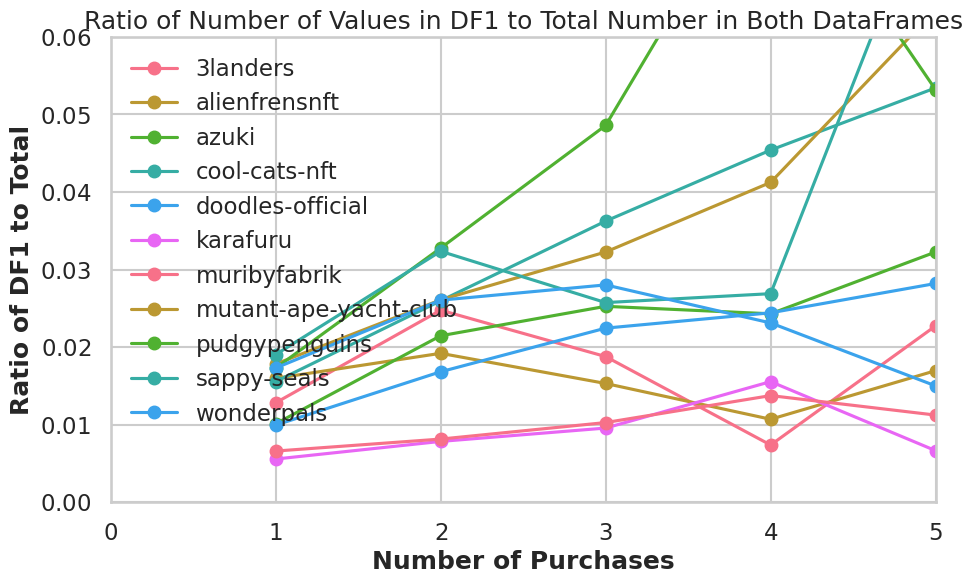

In [13]:
plt.figure(figsize=(10, 6))
for _,counts_combined in results:



    plt.plot(counts_combined.index, counts_combined['ratio'], marker='o', linestyle='-', label=_)
    # Customize the plot
plt.xlabel('Number of Purchases')
plt.ylabel('Ratio of DF1 to Total')
plt.title('Ratio of Number of Values in DF1 to Total Number in Both DataFrames')
plt.ylim(0, 0.06)  # Set y-axis limit to 1
plt.legend()
plt.xlim(0,5)
plt.grid(True)
    # plt.show()

,num_purchases,df1,df2,total,ratio
0,1,10985.0,859948.0,870933.0,0.012613
1,2,2633.0,127162.0,129795.0,0.020286
2,3,853.0,34127.0,34980.0,0.024385
3,4,354.0,11829.0,12183.0,0.029057
4,5,163.0,5064.0,5227.0,0.031184
5,6,87.0,2269.0,2356.0,0.036927
6,7,36.0,1082.0,1118.0,0.032200
7,8,25.0,565.0,590.0,0.042373
8,9,18.0,287.0,305.0,0.059016
9,10,9.0,188.0,197.0,0.045685


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


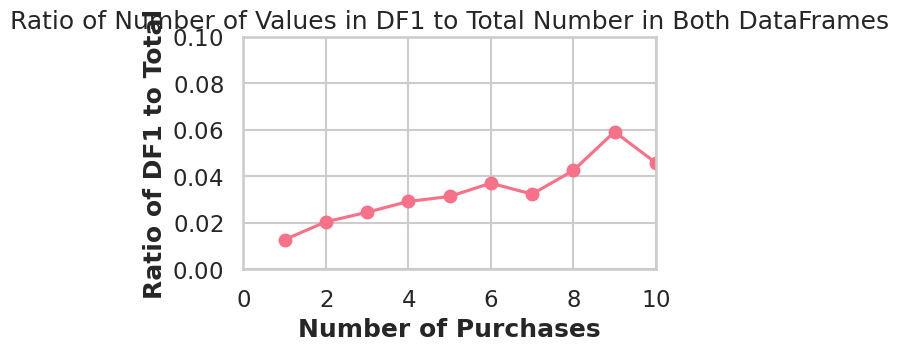

In [20]:
# Step 1: Concatenate all DataFrames in the list into a single DataFrame
result_dfs = [df for _,df in results]
combined_df = pd.concat(result_dfs)

# Step 2: Group by the num_purchases column
grouped_df = combined_df.groupby('num_purchases')

# Step 3: Sum the df1, df2, and total columns for each group
summed_df = grouped_df[['df1', 'df2', 'total']].sum().reset_index()
summed_df['ratio'] = summed_df['df1'] / summed_df['total']
display(summed_df)
plt.plot(summed_df['num_purchases'], summed_df['ratio'], marker='o', linestyle='-')
# Customize the plot
plt.xlabel('Number of Purchases')
plt.ylabel('Ratio of DF1 to Total')
plt.title('Ratio of Number of Values in DF1 to Total Number in Both DataFrames')
plt.ylim(0, 0.1)  # Set y-axis limit to 1
plt.legend()
plt.xlim(0,10)
plt.grid(True)
